In [31]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import shap
import time
from pyDOE import lhs
import sobol_seq

import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier

from tabulate import tabulate

In [32]:
# Apply XAI using SHAP
def apply_xai(model, X):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap_sum = np.abs(shap_values).mean(axis=0)
    return shap_sum
    
# Sampling functions
def random_sampling(data, sample_size=0.5):
    return data.sample(frac=sample_size, random_state=42)

def lhs_sampling(data, sample_size=0.5):
    n_samples = int(len(data) * sample_size)
    lhd = lhs(n=data.shape[1], samples=n_samples, criterion='center')
    scaled_samples = np.floor(lhd * len(data)).astype(int)
    return data.iloc[scaled_samples[:, 0]]

def monte_carlo_sampling(data, sample_size=0.5):
    sample_count = int(len(data) * sample_size)
    return data.sample(n=sample_count, replace=True)


def generate_stratified_table(data, n_strata):
    # Placeholder function to create a stratified table based on some criteria
    # This example will just return random strata for simplicity
    return np.array_split(data, n_strata)

def weighted_random_sampling(data, weights, n_samples):
    return data.sample(n=n_samples, weights=weights, replace=False)

def get_representative_vectors(data, sample_size=0.5, SC=10, W=None):
    N = int(len(data) * sample_size)
    # Step 7: Generate a joint cumulative distribution function if needed
    # This is just a placeholder: real implementation needed based on specific requirements
    data_pdf = data  # Using data directly as a placeholder
    
    # Step 8: Compute number of strata
    N_strata = np.floor(N / SC).astype(int)
    
    # Step 9: Generate stratified table
    data_strata = generate_stratified_table(data_pdf, N_strata)
    
    # Step 10-13: Calculate weights if not provided
    if W is None:
        W = []
        for stratum in data_strata:
            W.append(len(stratum) / len(data))
    
    # Step 14-16: Apply weights to determine the number of samples from each stratum
    S_strata = [int(w * N) for w in W]
    
    # Step 17-18: Collect samples from each stratum
    samples = []
    for stratum, n_samples in zip(data_strata, S_strata):
        samples.append(weighted_random_sampling(stratum, None, n_samples))  # None for weights if using uniform sampling within strata
    
    # Combine all samples into a single DataFrame
    representative_samples = pd.concat(samples, ignore_index=True)
    return representative_samples


def sobol_sampling(data, sample_size=0.5):
    num_samples = int(len(data) * sample_size)
    
    # Generate a Sobol sequence
    # The number of dimensions is equal to the number of features in the DataFrame
    sobol_samples = sobol_seq.i4_sobol_generate(data.shape[1], num_samples)
    
    # Scale the Sobol samples to span the range of each feature in the DataFrame
    min_vals = data.min().values
    max_vals = data.max().values
    scaled_samples = min_vals + (max_vals - min_vals) * sobol_samples
    
    # Use nearest indices to select rows from the DataFrame
    # This example uses simple rounding to map to nearest index - consider other methods for larger datasets
    indices = np.clip(np.round(scaled_samples).astype(int), 0, len(data) - 1)
    sampled_data = data.iloc[indices]
    
    return sampled_data

def improved_lhs_sampling(data, sample_size=0.5, optimization_iterations=5):
    n_samples = int(len(data) * sample_size)
    optimal_multiplier = 1.0  # Initial optimal multiplier

    # Initialize parameters for optimization
    for _ in range(optimization_iterations):
        # Perform sequential LHS with current parameters
        lhd = lhs(n=data.shape[1], samples=n_samples, criterion='center')
        scaled_samples = np.floor(lhd * len(data)).astype(int)
        sampled_data = data.iloc[scaled_samples[:, 0]]

        # Simulate state transitions and calculate new optimal multiplier
        # This is a simplified placeholder for the optimization step
        optimal_multiplier *= 0.95  # Assume each iteration refines the multiplier

    # Final sampling with the optimized parameters
    lhd = lhs(n=data.shape[1], samples=n_samples, criterion='center', iterations=optimal_multiplier)
    scaled_samples = np.floor(lhd * len(data)).astype(int)
    return data.iloc[scaled_samples[:, 0]]

def evaluate_model(model, y_test, preds):
    accuracy = sk.metrics.accuracy_score(y_test, preds)
    precision = sk.metrics.precision_score(y_test, preds)
    recall = sk.metrics.recall_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted')
    return accuracy, precision, recall, f1

In [5]:
train = pd.read_csv('data/processed/le_train.csv')
test = pd.read_csv('data/processed/le_test.csv')

X_train = train.drop(['id','attack_cat','label'], axis=1)
y_train = train['label'] #0 is normal, 1 is attack

X_test = test.drop(['id','attack_cat','label'], axis=1)
y_test = test['label']

In [ ]:
# knn, naive bayes, logistic regression, decision tree, random forest, xgboost
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    'knn': KNeighborsClassifier(),
    'naive_bayes': GaussianNB(),
    'logistic_regression': LogisticRegression(),
    'decision_tree': DecisionTreeClassifier(),
    'random_forest': RandomForestClassifier(),
    'xgboost': XGBClassifier()
}

results = {}
# Train all models
for name, model in tqdm(models.items()):
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    accuracy, precision, recall, f1 = evaluate_model(model, y_test, preds)
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [7]:
# tabulate
headers = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1']
table = []
for model, scores in results.items():
    table.append([model, round(scores['accuracy'],3), round(scores['precision'],3), round(scores['recall'],3), round(scores['f1'],3)])

print(tabulate(table, headers=headers, tablefmt='pretty'))

+---------------------+----------+-----------+--------+-------+
|        Model        | Accuracy | Precision | Recall |  F1   |
+---------------------+----------+-----------+--------+-------+
|         knn         |  0.423   |   0.786   |  0.21  | 0.383 |
|     naive_bayes     |  0.727   |   0.953   | 0.631  | 0.736 |
| logistic_regression |  0.776   |   0.926   |  0.73  | 0.784 |
|    decision_tree    |  0.676   |   0.953   | 0.552  | 0.683 |
|    random_forest    |  0.807   |   0.989   | 0.725  | 0.814 |
|       xgboost       |  0.819   |   0.963   | 0.764  | 0.825 |
+---------------------+----------+-----------+--------+-------+


In [11]:
xgb = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.01, objective='binary:logistic',tree_method='gpu_hist', random_state=42)

xgb.fit(X_train, y_train)
train_preds = xgb.predict(X_train)
test_preds = xgb.predict(X_test)


train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(xgb, y_train, train_preds)
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(xgb, y_test, test_preds)

#tabulate
results = [['Train', train_accuracy, train_precision, train_recall, train_f1],
           ['Test', test_accuracy, test_precision, test_recall, test_f1]]
print(tabulate(results, headers=['Dataset', 'Accuracy', 'Precision', 'Recall', 'F1 Score']))
    

Dataset      Accuracy    Precision    Recall    F1 Score
---------  ----------  -----------  --------  ----------
Train        0.935651     0.93536   0.94869     0.935595
Test         0.823635     0.969709  0.764767    0.829424


In [24]:
feature_importance = pd.DataFrame(columns=['feature', 'full_values'])
feature_importance['feature'] = X_train.columns
execution_times = pd.DataFrame(columns=['Sampling strategy', 'sample_size', 'Execution time'])

shap_sum = apply_xai(xgb, X_train)
feature_importance[f'full_values'] = shap_sum

In [25]:
sampling_methods = {
    'Weighted Sampling': get_representative_vectors,
    'random': random_sampling,
    'LHS': lhs_sampling,
    #'Sobol': sobol_sampling,
    'Improved LHS': improved_lhs_sampling,
    'Monte Carlo': monte_carlo_sampling,
}
sample_sizes = [0.1, 0.2, 0.3, 0.4, 0.5]

for name, method in tqdm(sampling_methods.items()):
    for sample_size in sample_sizes:
        len_samples = int(len(X_train) * sample_size)
        start_time = time.time()
        sampled_data = method(X_train, sample_size)
        end_time = time.time()

        execution_times = execution_times.append(
            {'Sampling strategy': name, 'sample_size': len_samples, 'Execution time': end_time - start_time}, ignore_index=True)
        
        shap_sum = apply_xai(xgb, sampled_data)
        feature_importance[f'{name}_{sample_size}'] = shap_sum

100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


In [18]:
execution_times.to_csv('data/execution_times.csv', index=False)

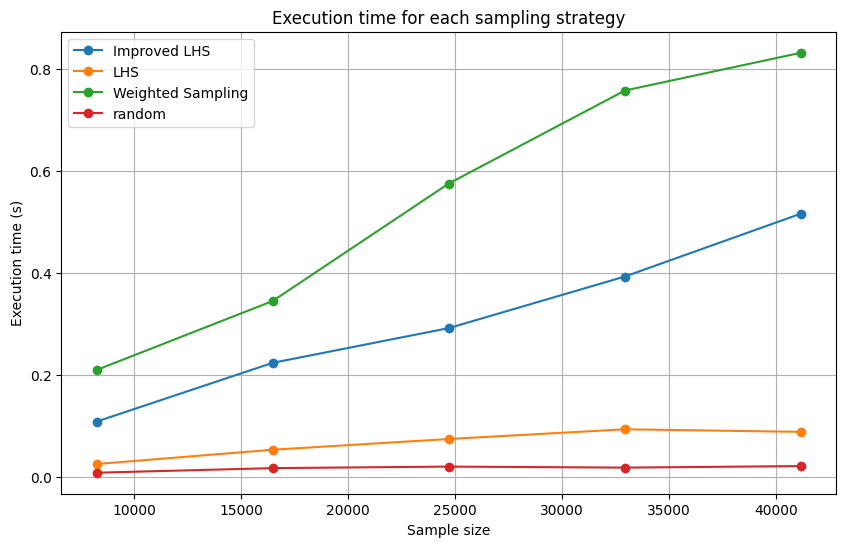

In [20]:
# line plot of execution times for each sampling strategy
plt.figure(figsize=(10, 6))
plt.title('Execution time for each sampling strategy')
for name, group in execution_times.groupby('Sampling strategy'):
    if name != "Monte Carlo":
        plt.plot(group['sample_size'], group['Execution time'], marker='o', label=name)
plt.xlabel('Sample size')
plt.ylabel('Execution time (s)')
plt.legend()
plt.grid()
plt.show()

In [21]:
tests = feature_importance.columns[2:]

top_features = feature_importance.sort_values(by='full_values', ascending=False)[['feature','full_values']]
all_losses = pd.DataFrame()
all_losses['sampling_method'] = tests

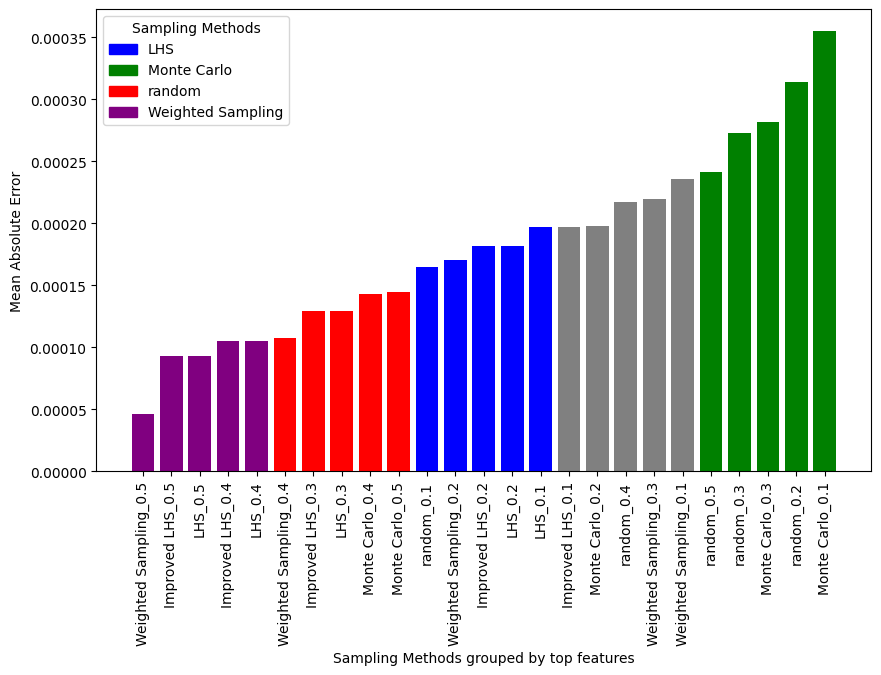

In [22]:
def calculate_loss(full_values, sampled_values):
    return np.abs(full_values - sampled_values).mean()

loss = []
for name in tests:
    loss.append(calculate_loss(feature_importance['full_values'], feature_importance[name]))
all_losses["ALL"] = loss

# Manually create a color map for each type of method
color_map = {
    'LHS': 'blue',
    'Monte Carlo': 'green',
    'random': 'red',
    'Weighted Sampling': 'purple'
}

# Set 'sampling_method' as the index
df = all_losses.copy()

df.set_index('sampling_method', inplace=True)

# Generate color list for the bars
colors = [color_map.get(name.split('_')[0], 'gray') for name in df.index]  # Default to 'gray' if key not found
df.sort_values(by='ALL', ascending=True, inplace=True)
# Using Matplotlib to create the bar plot to handle colors explicitly
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(df.index, df['ALL'], color=colors)

plt.xlabel('Sampling Methods grouped by top features')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=90)  # Rotate labels vertically

# Create legend handles manually
from matplotlib.patches import Patch
legend_handles = [Patch(color=color, label=label) for label, color in color_map.items()]
plt.legend(handles=legend_handles, title='Sampling Methods')
plt.show()

Experiments: 100%|██████████| 100/100 [14:05<00:00,  8.46s/it]


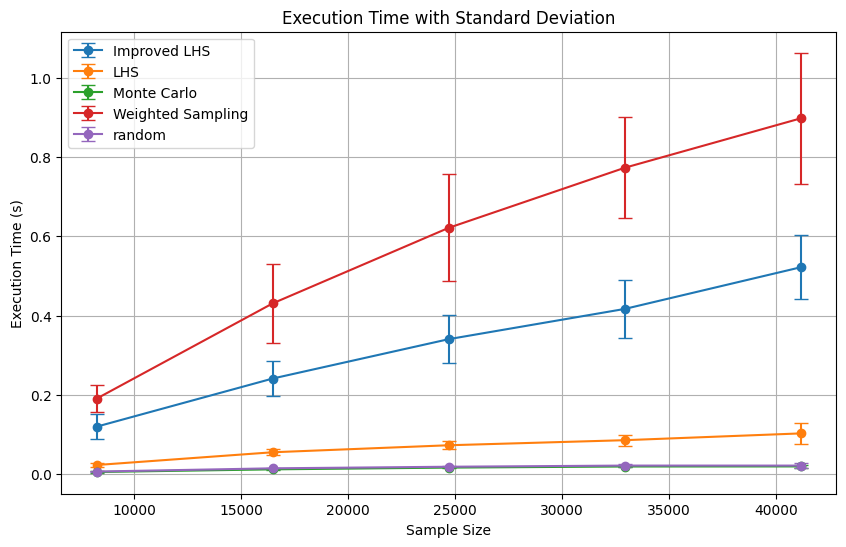

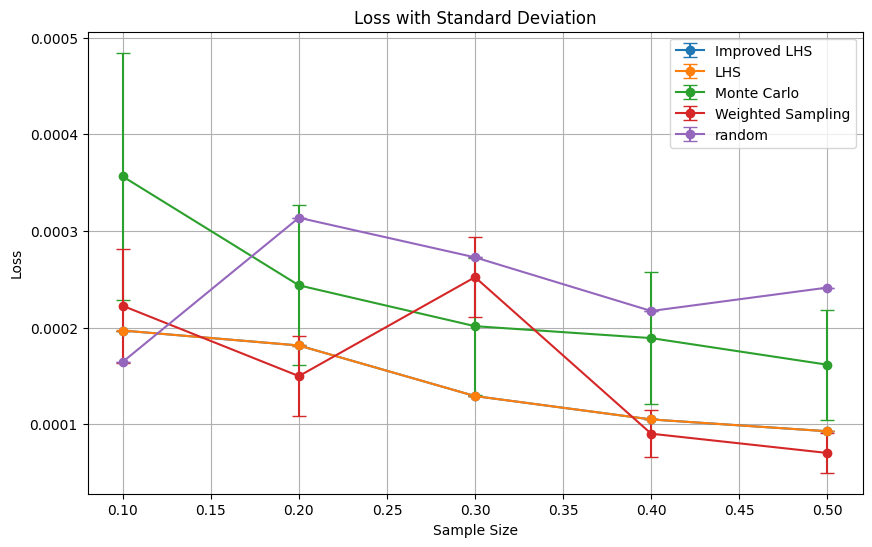

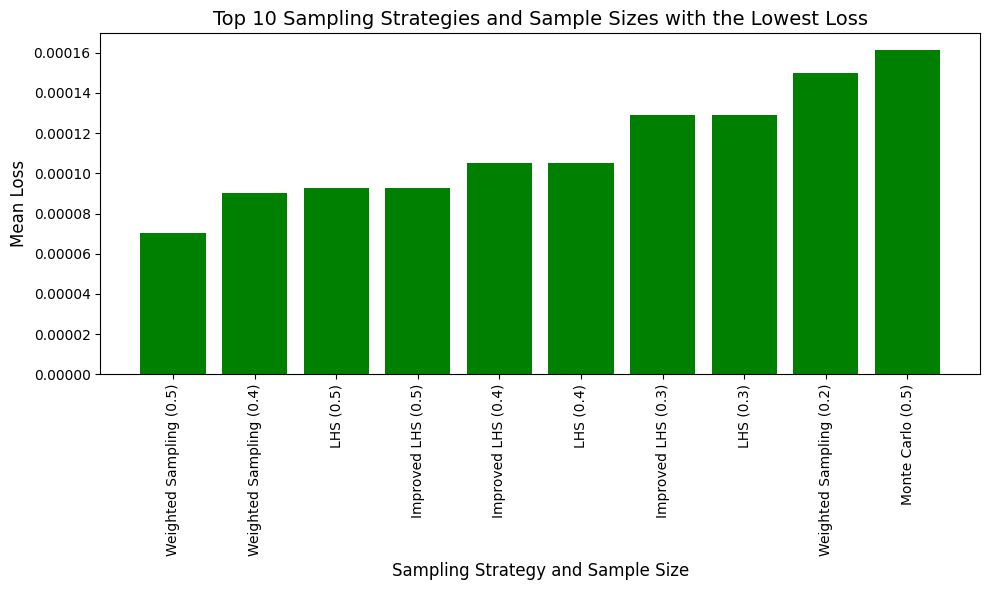

In [35]:
from tqdm.auto import tqdm

# Number of experiments
num_experiments = 100
sample_sizes = [0.1, 0.2, 0.3, 0.4, 0.5]

# Initialize storage for execution times and losses
exec_time_data = []
loss_data = []

for _ in tqdm(range(num_experiments), desc='Experiments'):
    # Loop over sampling strategies and sample sizes
    for name, method in sampling_methods.items():
        for sample_size in sample_sizes:
            len_samples = int(len(X_train) * sample_size)
            start_time = time.time()
            sampled_data = method(X_train, sample_size)
            end_time = time.time()

            # Record execution time
            exec_time_data.append({
                'Sampling strategy': name,
                'sample_size': len_samples,
                'Execution time': end_time - start_time
            })

            # Apply XAI and calculate loss
            shap_sum = apply_xai(xgb, sampled_data)
            loss = calculate_loss(feature_importance['full_values'], shap_sum)
            loss_data.append({
                'Sampling strategy': name,
                'sample_size': sample_size,
                'Loss': loss
            })

# Convert lists to DataFrames
exec_times_df = pd.DataFrame(exec_time_data)
loss_df = pd.DataFrame(loss_data)

# Calculate mean and std for execution times and loss
exec_summary = exec_times_df.groupby(['Sampling strategy', 'sample_size']).agg(['mean', 'std'])
loss_summary = loss_df.groupby(['Sampling strategy', 'sample_size']).agg(['mean', 'std'])

# Plotting results - Execution Time
fig, ax = plt.subplots(figsize=(10, 6))
for name, group in exec_summary.groupby(level=0):
    group = group.droplevel(0)  # Drop the sampling strategy from the index for plotting
    ax.errorbar(group.index, group[('Execution time', 'mean')], yerr=group[('Execution time', 'std')],
                label=name, fmt='-o', capsize=5)
ax.set_xlabel('Sample Size')
ax.set_ylabel('Execution Time (s)')
ax.legend()
ax.grid(True)
plt.title('Execution Time with Standard Deviation')
plt.show()

colors = ['navy', 'crimson', 'darkgreen', 'purple', 'goldenrod']
linestyles = ['-', '--', '-.', ':', (0, (3, 5, 1, 5))]
markers = ['o', 's', 'D', '^', '*']

# Plotting results - Loss
fig, ax = plt.subplots(figsize=(10, 6))
for name, group in loss_summary.groupby(level=0):
    group = group.droplevel(0)  # Drop the sampling strategy from the index for plotting
    ax.errorbar(group.index, group[('Loss', 'mean')], yerr=group[('Loss', 'std')],
                label=name, fmt='-o', capsize=5)
ax.set_xlabel('Sample Size')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True)
plt.title('Loss with Standard Deviation')
plt.show()

# Calculate the mean loss for each combination of strategy and sample size
mean_loss_df = loss_df.groupby(['Sampling strategy', 'sample_size']).mean().reset_index()

# Find the top 5 results with the lowest loss
top_5_results = mean_loss_df.nsmallest(10, 'Loss')

# Plotting the top 5 results
fig, ax = plt.subplots(figsize=(10, 6))

# Since 'Sampling strategy' and 'sample_size' are categorical, we need a composite key to plot
top_5_results['Strategy_Size'] = top_5_results['Sampling strategy'] + ' (' + top_5_results['sample_size'].astype(str) + ')'

ax.bar(top_5_results['Strategy_Size'], top_5_results['Loss'], color='green')

ax.set_xlabel('Sampling Strategy and Sample Size', fontsize=12)
ax.set_ylabel('Mean Loss', fontsize=12)
ax.set_title('Top 10 Sampling Strategies and Sample Sizes with the Lowest Loss', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels

plt.show()
